In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2026-02-03 05:22:29.234276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770096149.418101      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770096149.465670      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770096149.885490      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770096149.885534      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770096149.885537      24 computation_placer.cc:177] computation placer alr

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-village/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=[
        "Potato___Early_blight",
        "Potato___Late_blight",
        "Potato___healthy"
    ]
)

Found 2152 files belonging to 3 classes.


I0000 00:00:1770096166.380246      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770096166.386320      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# each element is of 32 batch so actual len = 32 * 68
len(dataset)

68

In [6]:
# Shape of 1st image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


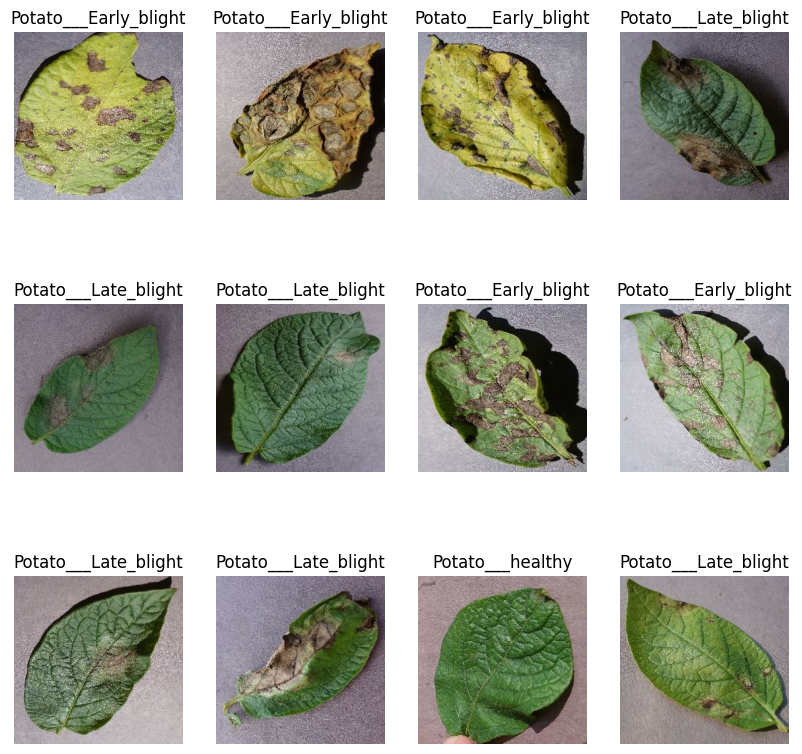

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+ 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Data Split:  
80% ==> training  
20% ==> 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
remaining_ds = dataset.skip(54)
len(remaining_ds)

14

In [11]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [12]:
val_ds = remaining_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = remaining_ds.skip(6)
len(test_ds)

8

In [14]:
# Function for the train, test and validation split 
def get_dataset_partition_df(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partition_df(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [22]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, *input_shape))

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


I0000 00:00:1770096177.687471      74 cuda_dnn.cc:529] Loaded cuDNN version 91002


54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.4850 - loss: 0.9363 - val_accuracy: 0.5312 - val_loss: 0.8726
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6808 - loss: 0.6775 - val_accuracy: 0.7969 - val_loss: 0.4890
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7885 - loss: 0.4784 - val_accuracy: 0.8698 - val_loss: 0.2857
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8727 - loss: 0.3015 - val_accuracy: 0.9531 - val_loss: 0.1605
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9044 - loss: 0.2582 - val_accuracy: 0.8854 - val_loss: 0.2772
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9389 - loss: 0.1714 - val_accuracy: 0.9010 - val_loss: 0.2231
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9472 - loss: 0.1519 - val_accuracy: 0.9583 - val_loss: 0.1216
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9518 - loss: 0.1268 - val_accuracy: 0.9323 - val_loss: 0

In [26]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9934 - loss: 0.0258


In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

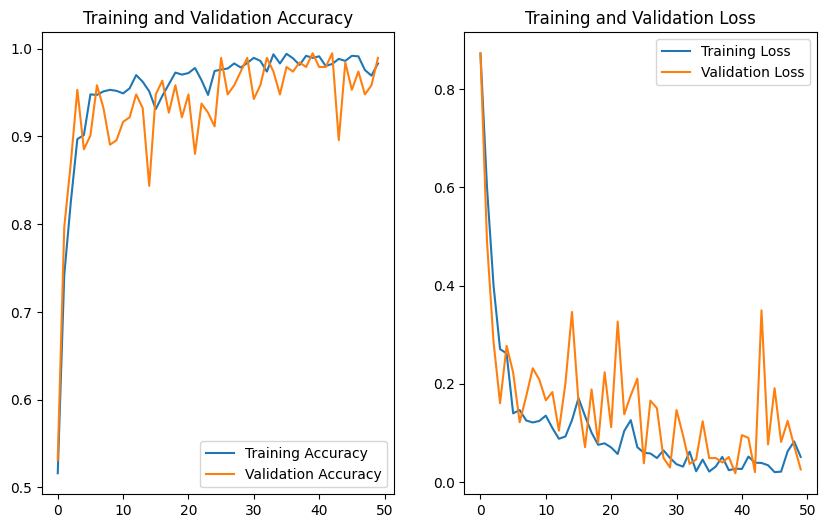

In [30]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

First Image To predict:
Actual Label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Predicted Label:  Potato___Early_blight


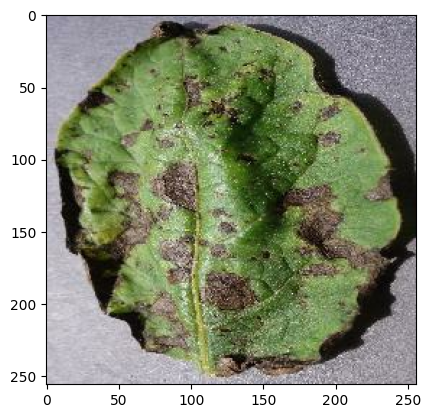

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First Image To predict:")
    plt.imshow(first_image)
    print("Actual Label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    # Convert image to array
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())

    # Add batch dimension
    img_array = tf.expand_dims(img_array, 0)

    # Make prediction
    predictions = model.predict(img_array)

    # Get class index
    predicted_index = np.argmax(predictions[0])

    # Get class name & confidence
    predicted_class = class_names[predicted_index]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


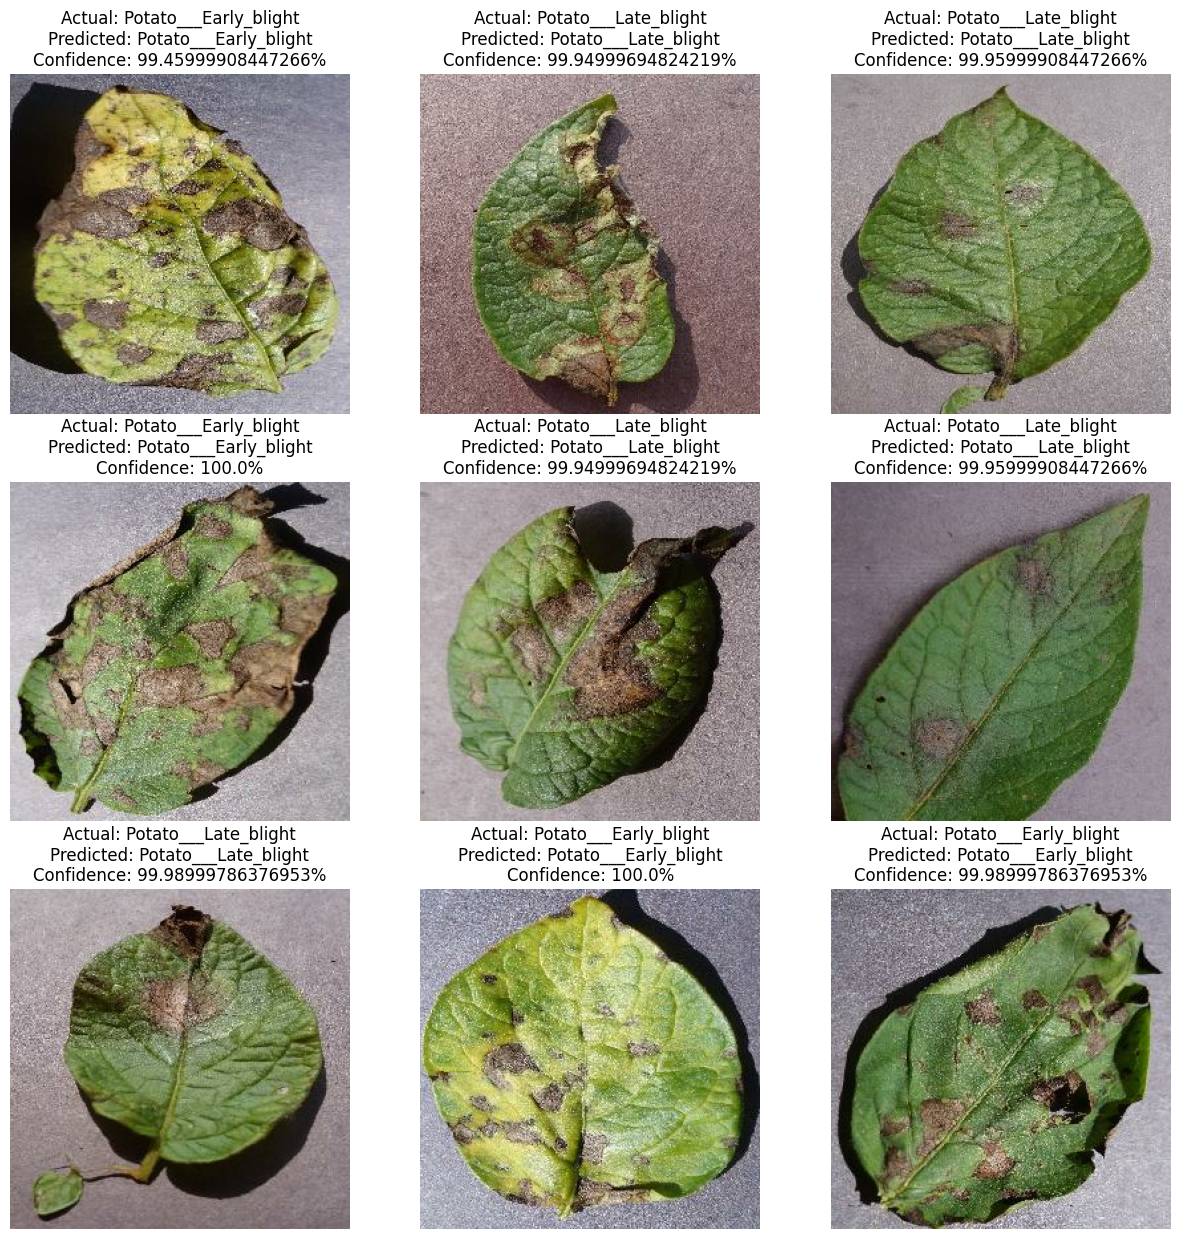

In [33]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(
            f"Actual: {actual_class}\n"
            f"Predicted: {predicted_class}\n"
            f"Confidence: {confidence}%"
        )

        plt.axis("off")

plt.show()


In [34]:
model.save("potato_disease_model.h5")

In [35]:
model.save("potato_disease_model.keras")